## Modeling Notebook

<a id="top"></a>
Jump to
- [Classical Regression](#regression)
- [Deep Learning](#deep_learning)

#### Load request modules

In [486]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from pickle import dump
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import root_mean_squared_error

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Flatten, Dense, InputLayer
from tensorflow.keras.metrics import R2Score
from sklearn.preprocessing import MinMaxScaler

#### Load data

In [5]:
raw_env_air_df = pd.read_parquet('../data/processed/air_quality_hotspot_data-20241101_20241130.parquet')

#### Merge environment and satellite hotspot data

In [112]:
# limit date range
env_air_df = raw_env_air_df.reset_index().copy()
env_air_df = env_air_df[
(env_air_df['date']>='2024-11-27 00:00:00+00:00') & \
(env_air_df['date']<='2024-11-30 23:59:59+00:00')].reset_index().copy() #.set_index(['date','latitude','longitude'])

In [113]:
# set coordinate degree step
def downsamping(env_air_df, loc_step=0.5):
    df = env_air_df.copy().drop(columns=['index'])
    round_div = 1 / loc_step
    
    # downsampling coordinate
    df['latitude'] = (df['latitude'] * round_div).round() / round_div
    df['longitude'] = (df['longitude'] * round_div).round() / round_div
    res = df.groupby(['date','latitude','longitude']).mean()
    
    return res

In [116]:
# set momdel variables
def split_data(avg_env_air_df):
    X = avg_env_air_df[[c for c in avg_env_air_df.columns if c not in ['pm10','pm2_5','carbon_monoxide','nitrogen_dioxide','sulphur_dioxide','ozone','dust']]]
    y = avg_env_air_df[['pm2_5']]
    X.shape, y.shape
    
    # # split data for train and test
    return train_test_split(X, y, train_size=0.8, random_state=42)

#### Defined models

In [118]:
def run_model(models, X_train, X_test, y_train, y_test):
    scores = []
    
    for i, model in enumerate(models):
        if 'Forest' in model['name'] and type(y_train) == pd.DataFrame:
            y_train = y_train.values.ravel()
            y_test = y_test.values.ravel()
        grid = GridSearchCV(model['pipeline'], param_grid=model['param'], n_jobs=8, cv=5)
        grid.fit(X_train, y_train)
        models[i]['fit_model'] = grid.best_estimator_.fit(X_train, y_train)
        models[i]['model'] = grid.best_estimator_
        print(f'Running model: {i}. {model["name"]}')
        preds = grid.predict(X_test)
        #plot_pred(y_test, preds)
        scores.append({'name':model['name'],
                       'cv_score': grid.best_score_,
                       'train_score': grid.best_estimator_.score(X_train, y_train),
                       'test_score': grid.best_estimator_.score(X_test, y_test),
                       'test_rmse': root_mean_squared_error(y_test, preds),
                      })
    print('-'*70)
    score_df = pd.DataFrame(scores).set_index('name')
    return models, score_df

---

In [120]:
# plot test vs. predict
def plot_pred(y_test, preds):
    sns.scatterplot(x=pd.Series(y_test.values[:,-1]), y=pd.Series(preds));
    plt.title('Test vs. Predict')
    plt.xlabel('Test')
    plt.ylabel('Predict')
    plt.show()

In [122]:
# preprocess data
avg_env_air_df = downsamping(env_air_df, loc_step=0.5)
X_train, X_test, y_train, y_test = split_data(avg_env_air_df)

In [14]:
#avg_env_air_df.head(5)

models = [
    {'name': 'Linear Regression',
     'pipeline': Pipeline([
                ('sc', StandardScaler()),
                ('lr', LinearRegression())
              ]), 
     'param': {
     }
    },
    {'name': 'XGBoost',
     'pipeline': Pipeline([
                ('sc', StandardScaler()),
                ('xgb', xgb.XGBRFRegressor())
             ]), 
     'param': {'xgb__learning_rate': [1]}
    },
    {'name': 'ElasticNet',
     'pipeline': Pipeline([
                ('sc', StandardScaler()),
                ('esn', ElasticNet())
             ]), 
     'param': {
         'esn__alpha': [0.1, 0.5, 1],
         'esn__max_iter': [10, 100, 500, 1000],
     }
    },
    {'name': 'Random Forest',
     'pipeline': Pipeline([
                ('sc', StandardScaler()),
                ('rf', RandomForestRegressor())
             ]), 
     'param': {},
    },
    {'name': 'Random Forest PCA',
     'pipeline': Pipeline([
                ('sc', StandardScaler()),
                ('pca', PCA()),
                ('rf', RandomForestRegressor())
             ]), 
     'param': {},
    },
]

models, scores = run_model(models, X_train, X_test, y_train, y_test)

Running model: 0. Linear Regression
Running model: 1. XGBoost
Running model: 2. ElasticNet
Running model: 3. Random Forest
Running model: 4. Random Forest PCA
----------------------------------------------------------------------


<a id='regression'></a>
#### Classical Regression
[Top](#top)

In [15]:
scores.sort_values(by='cv_score', ascending=False).round(2)

,cv_score,train_score,test_score,test_rmse
name,,,,
Random Forest,0.83,0.98,0.83,2.69
Random Forest PCA,0.79,0.97,0.79,2.97
XGBoost,0.62,0.64,0.59,4.15
Linear Regression,0.48,0.48,0.46,4.73
ElasticNet,0.46,0.46,0.44,4.82


#### Choose and save the RandomForestRegressor
It has highest cross validation score and lowest RMSE

In [36]:
# fit the model
model = RandomForestRegressor()
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)
model.fit(X_train_sc, y_train.values.ravel())

# save model
with open('../data/processed/model_rf_20241127_30.pkl', 'wb') as f:
     dump(model, f, protocol=5)

In [37]:
# find importance features
feature_df = pd.DataFrame({'importances': model.feature_importances_, 
                           'feature': X_train.columns
                          })
feature_df.sort_values(by='importances', ascending=False)

,importances,feature
3,0.307351,pressure_msl
0,0.107632,temperature_2m
4,0.099965,surface_pressure
2,0.080252,dew_point_2m
16,0.072654,uv_index
6,0.045496,wind_speed_80m
9,0.044240,wind_direction_10m
8,0.036925,wind_speed_180m
5,0.034412,wind_speed_10m
1,0.032282,relative_humidity_2m


<a id='deep_learning'></a>
#### Deep Learning
Long Short-Term Memory (LSTM)

[Top](#top)

In [609]:
def rmse(y_true, y_pred):
    return tf.sqrt(tf.keras.losses.MSE(y_true, y_pred))

In [569]:
mms = MinMaxScaler(feature_range=(-1, 1))
X_train_sc = mms.fit_transform(X_train)
X_test_sc = mms.transform(X_test)

X_train_dl = np.reshape(X_train, (int(X_train_sc.shape[0]/3), 3, X_train.shape[1]))
X_test_dl = np.reshape(X_test, (int(X_test_sc.shape[0]/3), 3, X_test.shape[1]))
y_train_dl = np.reshape(y_train, (int(y_train.shape[0]/3), 3, y_train.shape[1]))
y_test_dl = np.reshape(y_test, (int(y_test.shape[0]/3), 3, y_test.shape[1]))

In [605]:
# setup the RNN model
model = Sequential()
# number_sampling, 
model.add(InputLayer(shape=(3, X_train.shape[1])))
model.add(LSTM(64, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[rmse])

# train the model
hist = model.fit(X_train_dl, y_train_dl, epochs=50, batch_size=72, verbose=0, 
                 validation_data=(X_test_dl, y_test_dl))

In [583]:
def plot_model(model, X_test, y_test, history):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    # plot training loss vs validation loss#
    ax[0].plot(history.history['loss'], label='Training Loss')
    ax[0].plot(history.history['val_loss'], label='Validation Loss')
    ax[0].set_title('Training loss vs validation loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].legend()
    
    ax[1].set_title('Training RMSE vs validation RMSE')
    ax[1].plot(history.history['rmse'], label='Training RMSE')
    ax[1].plot(history.history['val_rmse'], label='Validation RMSE')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('MSE')
    ax[1].legend()

    # show evaluate model MSE
    preds = model.predict(X_test, verbose=0)
    plt.suptitle(f'Model Testing RMSE: {round(root_mean_squared_error(y_test[:,-1], preds[:,-1]), 4)}')
    plt.show()

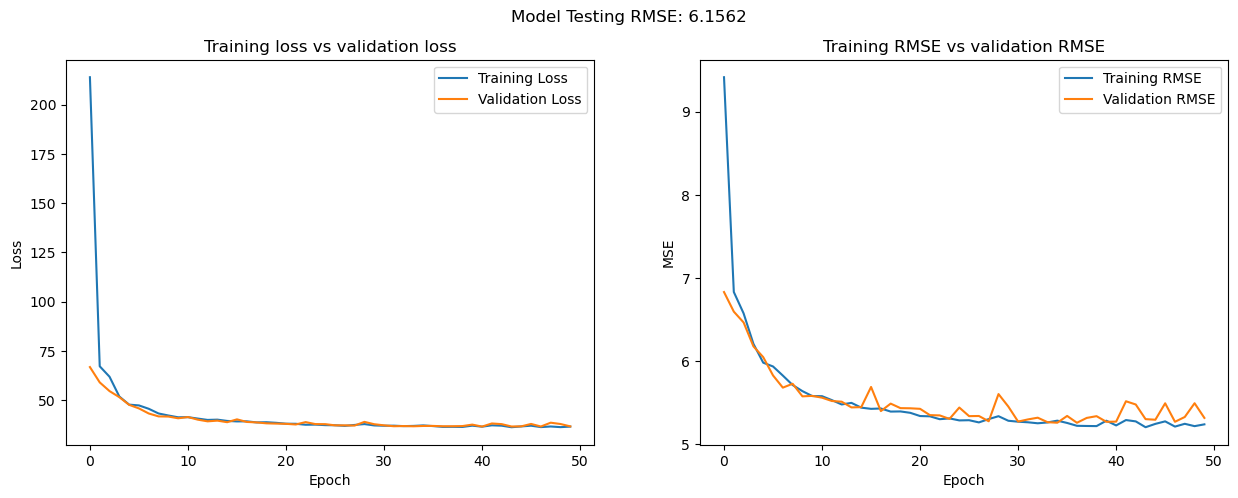

In [607]:
plot_model(model, X_test_dl, y_test_dl, hist)